In [1]:
import numpy as np 
import pandas as pd
import datetime as dt
from netCDF4 import Dataset
import xarray as xr 
import rioxarray
# import xesmf as xe
# from pyresample import geometry
import os 

Grid point max ERM:
29.8


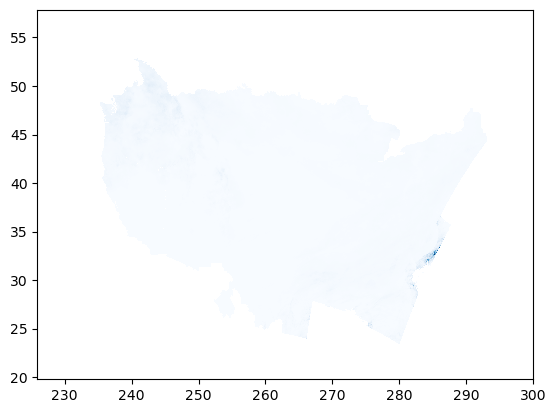

In [5]:
# Calculate rainfall accumuation: Stage IV analysis 
data_dir = '/home/orca/bkerns/projects/doe_coastal/extreme_rain/global_gridded_erm/data/processed/erm_by_year'
date_start = dt.datetime(2025, 12, 1)
date_end = dt.datetime(2025, 12, 15)
date_list = pd.date_range(start=date_start, end=date_end, freq='24h')

# Get lat/lon from one historical data file.
fn = os.path.join(
    '/home/orca/data/in_situ/NCEP_stageIV_QPE/2025/daily',
    'st4_conus.2025010112.24h.nc')

with xr.open_dataset(fn) as ds:
    lats = ds['latitude'].data
    lons = ds['longitude'].data

fn1 = os.path.join(
    data_dir,
    'precip_and_erm_3day.s4.2006_2020.2025.nc'
)

with xr.open_dataset(fn1) as ds:

    ds1 = ds.sel(time=slice(date_start, date_end))
    lons = ds1['lon'].data
    lats = ds1['lat'].data

    max_erm = ds1['daily_3day_erm'].max(dim='time').values

    print(f'Grid point max ERM:')
    print(np.nanmax(max_erm))

plt.pcolormesh(lons, lats, max_erm, cmap='Blues')

KDTree built.
Query the KDTree. This may take awhile.
2026-02-04 15:43:16.583746
(15.715455304698837, np.int64(212206))
2026-02-04 15:43:57.201918
[15.7154553  15.70947561]
[212206 212206]
Apply the indices from the KDTree.
29.8


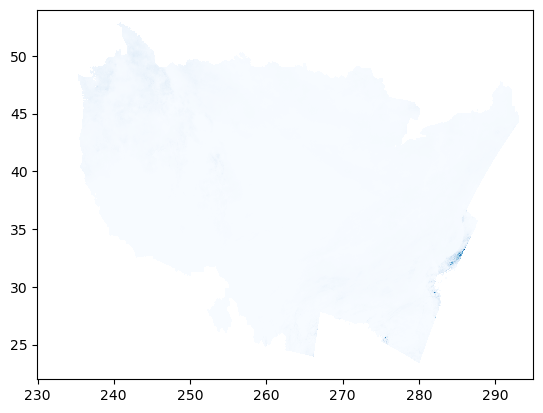

In [6]:
from functions import do_query

target_lats = np.arange(22.0, 54.01, 0.01)
target_lons = np.arange(230.0, 295.01, 0.01)

target_lon_grid, target_lat_grid = np.meshgrid(target_lons, target_lats)

target_lon_grid_1d = target_lon_grid.flatten()
target_lat_grid_1d = target_lat_grid.flatten()

# Define source and target geometries
source_lon_1d = lons.flatten()
source_lat_1d = lats.flatten()
source_max_erm_1d = max_erm.flatten()
keep_mask = ~np.isnan(source_max_erm_1d)
source_lat_1d = source_lat_1d[keep_mask]
source_lon_1d = source_lon_1d[keep_mask]
source_max_erm_1d = source_max_erm_1d[keep_mask]

# Nearest neighbor interpolation to a regular lat-lon grid.



from scipy.spatial import KDTree

KD = KDTree(np.array([source_lon_1d, source_lat_1d]).T)
print("KDTree built.")

## Query which ETOPO01 points are closest to each HYCOM grid point.
print('Query the KDTree. This may take awhile.')

import multiprocessing
NP = 12
print(dt.datetime.now())

output = do_query(0, KD, target_lon_grid_1d, target_lat_grid_1d)
print(output)

with multiprocessing.Pool(processes=NP) as pool:
    Q = pool.starmap(do_query, [(i, KD, target_lon_grid_1d, target_lat_grid_1d) for i in range(len(target_lon_grid_1d))])

print(dt.datetime.now())

# Q comes out as a list of tuples (distance, index)
# I need to separate the distances and indices.

Qdistances = np.array([x[0] for x in Q])
Qindices = np.array([x[1] for x in Q])

print(Qdistances[0:2])
print(Qindices[0:2])


print('Apply the indices from the KDTree.')
distance_threshold = 0.05  # degrees
max_erm_interp_1d = np.where(Qdistances < distance_threshold, source_max_erm_1d[Qindices], np.nan)

max_erm_interp = max_erm_interp_1d.reshape(target_lon_grid.shape)
print(np.nanmax(max_erm_interp))
plt.pcolormesh(target_lons, target_lats, max_erm_interp, cmap='Blues')

In [7]:

# Create xarray dataset with precip, lon, and lat
max_erm_ds = xr.Dataset(
    data_vars={
        'max_erm': (['y', 'x'], max_erm_interp)
    },
    coords={
        'y': (['y',], target_lats),
        'x': (['x',], target_lons)
    }
)

max_erm_ds['max_erm'].attrs["units"] = "1"
max_erm_ds['max_erm'].attrs["long_name"] = "Maximum ERM"
max_erm_ds['max_erm'].rio.write_nodata(0, inplace=True)


print(max_erm_ds)

# Export to GeoTIFF
# MUST use web mercator!
max_erm_ds = max_erm_ds.rio.write_crs("EPSG:4326")
max_erm_3857 = max_erm_ds.rio.reproject(
    "EPSG:3857",
    resolution=2000,  # meters (roughly your 4 km grid)
    resampling="nearest"
)

max_erm_3857.rio.to_raster(
    "max_erm_4km.tif",
    driver="COG",
    compress="DEFLATE",
    dtype="float32",
    nodata=-9999
)





<xarray.Dataset> Size: 83MB
Dimensions:  (y: 3201, x: 6501)
Coordinates:
  * y        (y) float64 26kB 22.0 22.01 22.02 22.03 ... 53.97 53.98 53.99 54.0
  * x        (x) float64 52kB 230.0 230.0 230.0 230.0 ... 295.0 295.0 295.0
Data variables:
    max_erm  (y, x) float32 83MB nan nan nan nan nan nan ... nan nan nan nan nan


In [8]:
data = rioxarray.open_rasterio('max_erm_4km.tif')
data

<xarray.DataArray (band: 1, y: 2330, x: 3619)> Size: 34MB
[8432270 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * y            (y) float64 19kB 7.17e+06 7.168e+06 ... 2.514e+06 2.512e+06
  * x            (x) float64 29kB -1.447e+07 -1.447e+07 ... -7.235e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    long_name:      Maximum ERM
    units:          1
    _FillValue:     0.0
    scale_factor:   1.0
    add_offset:     0.0

<xarray.DataArray (band: 1, y: 2330, x: 3619)> Size: 34MB
[8432270 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * y            (y) float64 19kB 7.17e+06 7.168e+06 ... 2.514e+06 2.512e+06
  * x            (x) float64 29kB -1.447e+07 -1.447e+07 ... -7.235e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    long_name:      Maximum ERM
    units:          1
    _FillValue:     0.0
    scale_factor:   1.0
    add_offset:     0.0


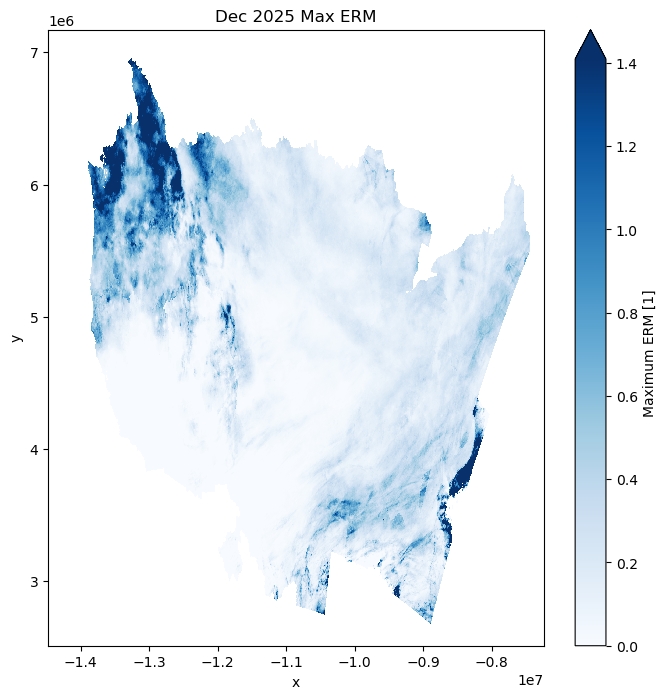

In [11]:
# Plot the raster data

data = rioxarray.open_rasterio('max_erm_4km.tif')
print(data)
plt.figure(figsize=(8, 8))

vmin = data.quantile(0.02).item()
vmax = data.quantile(0.98).item()

data.isel(band=0).plot.imshow(
    vmin=vmin,
    vmax=vmax,
    cmap="Blues"
)


plt.title('Dec 2025 Max ERM')
plt.show()

In [12]:
help(max_erm_ds.rio.reproject)

Help on method reproject in module rioxarray.raster_dataset:

reproject(
    dst_crs: Any,
    *,
    resolution: Optional[Union[float, tuple[float, float]]] = None,
    shape: Optional[tuple[int, int]] = None,
    transform: Optional[Affine] = None,
    resampling: Optional[Union[Resampling | str]] = <Resampling.nearest: 0>,
    nodata: Optional[float] = None,
    **kwargs
) -> xarray.Dataset method of rioxarray.raster_dataset.RasterDataset instance
    Reproject :class:`xarray.Dataset` objects

    .. note:: Only 2D/3D arrays with dimensions 'x'/'y' are currently supported.
        Others are appended as is.
        Requires either a grid mapping variable with 'spatial_ref' or
        a 'crs' attribute to be set containing a valid CRS.
        If using a WKT (e.g. from spatiareference.org), make sure it is an OGC WKT.

    .. note:: To re-project with dask, see
        `odc-geo <https://odc-geo.readthedocs.io/>`__ &
        `pyresample <https://pyresample.readthedocs.io/>`__.

    ..

In [13]:
import rasterio

url = "https://gaia-hazlab-map-data.s3.us-west-2.amazonaws.com/max_erm_4km.tif"
with rasterio.open(url) as src:
    print("CRS:", src.crs)
    print("Width x Height:", src.width, src.height)
    print("Number of bands:", src.count)
    print("Nodata value:", src.nodata)
    print("Min / Max:", src.read(1).min(), src.read(1).max())


CRS: EPSG:3857
Width x Height: 3619 2330
Number of bands: 1
Nodata value: 0.0
Min / Max: nan nan
